# CNN + Transfer learning

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for i in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)
print(len(physical_devices), 'devices detect')

4 devices detect


In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Flatten, GlobalAveragePooling2D)
import tensorflow as tf

## Where AM I 資料讀入及前處理

In [3]:
data_path = "dataset/train"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots.split("/")[-1], each))
            y_data_list.append(roots.split("/")[-1])

In [4]:
data_list = pd.DataFrame({})
data_list['img_path'] = x_data_list
data_list['label'] = y_data_list

In [5]:
data_list.head(3)

,img_path,label
0,Digimon/120px-Biostegomon.png,Digimon
1,Digimon/120px-Atlurkabuterimon_red.jpg,Digimon
2,Digimon/120px-Aegiochusmon_dark.jpg,Digimon


In [6]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(data_list,
                                         test_size=0.1,
                                         random_state=42,
                                         stratify=data_list['label'].values)

In [7]:
img_size = 224
num_class = len(data_list['label'].unique())

## 讀入 Pre-trained Model

In [8]:
from tensorflow.keras.applications.resnet import (ResNet50, preprocess_input)

In [9]:
pre_model = ResNet50(weights='imagenet', include_top=False,
                     input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(pre_model.output)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(num_class, activation='softmax')(x)


model = Model(inputs=pre_model.inputs, outputs=outputs)

In [10]:
# model.summary()

# 決定 Pre-Train 參數量

In [11]:
pre_model.trainable = True

# trainable_layer = 10
# for layer in pre_model.layers[:-trainable_layer]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

# model.summary()

In [12]:
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Data Augmentation

In [13]:
batch_size = 32
num_steps = len(train_list) // batch_size + 1
num_epochs = 10

In [14]:
train_datagen = ImageDataGenerator(
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input
                                  )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [15]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=test_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

# 用在不知道 label 的資料讀取上
# test_generator = test_datagen.flow_from_dataframe(
#                                                     dataframe=test_list,
#                                                     directory=data_path,
#                                                     x_col="img_path",
#                                                     target_size=img_shape,
#                                                     batch_size=batch_size,
#                                                     class_mode=None,
#                                                     shuffle=False)


Found 1657 validated image filenames belonging to 2 classes.
Found 185 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 7 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


## 開始訓練模型

In [16]:
model_dir = 'model-logs/resnet50'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [21]:
history = model.fit(train_generator,
                              epochs=num_epochs,
                              validation_data=valid_generator,
                              callbacks=callbacks_list)

Train for 52 steps, validate for 6 steps
Epoch 1/10
52/52 [==============================] - 36s 683ms/step - loss: 0.0147 - accuracy: 0.9988 - val_loss: 0.0188 - val_accuracy: 0.9892
Epoch 2/10
52/52 [==============================] - 34s 658ms/step - loss: 0.0091 - accuracy: 0.9994 - val_loss: 0.0120 - val_accuracy: 0.9946
Epoch 3/10
52/52 [==============================] - 34s 652ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 0.9946
Epoch 4/10
52/52 [==============================] - 34s 649ms/step - loss: 0.0043 - accuracy: 0.9994 - val_loss: 0.0080 - val_accuracy: 0.9946
Epoch 5/10
52/52 [==============================] - 34s 658ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 6/10
52/52 [==============================] - 34s 657ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 7/10
52/52 [==============================] - 34s 650ms/step - loss: 0.0020 - accuracy: 1.0000 

## 訓練結果視覺化

In [22]:
loss, acc = model.evaluate_generator(valid_generator, verbose=2)

6/6 - 1s - loss: 0.0037 - accuracy: 1.0000


In [23]:
y_pred = model.predict_generator(valid_generator)
y_pred = y_pred.argmax(-1)

In [24]:
y_test = valid_generator.classes
class_name = valid_generator.class_indices
class_names = np.array([each for each in class_name.keys()])

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

1.0
[[105   0]
 [  0  80]]


Text(0.5, 1, 'Confusion Matrix')

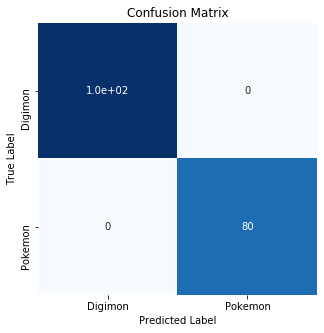

In [26]:
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

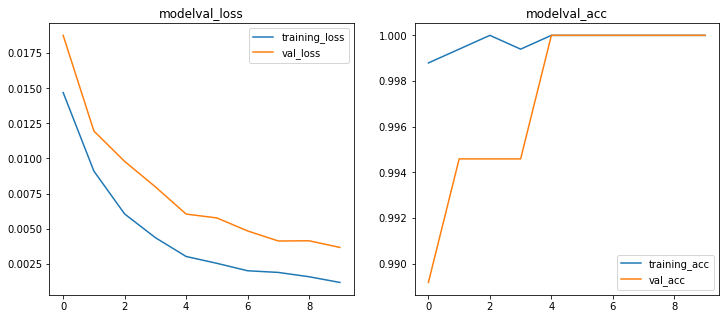

In [27]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model'+eachy)
plt.show()